# Object detection #4
sources: https://pyimagesearch.com/2020/07/13/r-cnn-object-detection-with-keras-tensorflow-and-deep-learning/, https://towardsdatascience.com/step-by-step-r-cnn-implementation-from-scratch-in-python-e97101ccde55

Implement an RCNN object detector given the techniques we've learnt previously.

We will use selective search to generate ROIs then use these ROIs as our training data to classify objects from our dataset.

## Summary
RCNN object detection and classification pipeline:

1) Build object detection dataset with selective search (calculate IOU on proposed region with ground truth data and add labels to proposed regions)

2) Fine-tune classification model on dataset (utilize transfer learning)

3) During inference run selective search on input image

4) Make predictions on each ROI using fine tuned model, apply NMS and return results

*IOU: intersection over union

## Dependencies

In [1]:
import tensorflow as tf
from keras import Model
from keras import optimizers
from keras.layers import Dense
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import time
import os

## NMS
non-maxima suppression (NMS) removes redundant bboxes by discarding those that has overlaps above a given threshold

In [2]:
# Felzenszwalb et al.
# boxes should be defined as [(start_x, start_y, end_x, end_y),...]
def NMS(boxes, overlapThresh):
    if len(boxes) == 0:
        return []
    # picked indexes
    pick = []
    # coords of all bboxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    # compute area of bboxes
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    # get indexes sorted by bottom right coord
    idxs = np.argsort(x1)
    # while there are still bboxes not checked
    while len(idxs) > 0:
        # grab the last idx
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i) # list of boxes picked (curr is cfm picked as overlapped bboxes are discarded beforehand)
        suppress = [] # list of boxes to be deleted
        idxs = idxs[:-1]
        # compare all bboxes with last
        for pos in range(0, last):
            j = idxs[pos]
            # compare box i and j for overlap
            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])
            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)
            overlap = float(w * h) / area[j]
            # overlap above threshold? Pos to be deleted
            if overlap > overlapThresh:
                suppress.append(pos)
        # delete all indexes from the index list that are in suppression list
        idxs = np.delete(idxs, suppress)
    # only picked boxes returned
    return boxes[pick]

## Selective search

In [3]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
def selective_search(img, print_info=False):
    ss.setBaseImage(img)
    # use fast quality
    ss.switchToSelectiveSearchFast()
    start = time.time()
    rects = ss.process()
    end = time.time()
    if print_info:
        print('Selective search took {:.4f}s'.format(end - start))
        print('{} total region proposals'.format(len(rects)))
    return rects

## IOU
IOU value = overlap area : non-overlap area. For the dataset building phase we need to get the IOU of the ground truth box with the ROI from selective search.

In [4]:
def get_iou(bb1, bb2):
    x1 = max(bb1[0], bb2[0])
    y1 = max(bb1[1], bb2[1])
    x2 = min(bb1[2], bb2[2])
    y2 = min(bb1[3], bb2[3])
    # no contact
    if x2 < x1 or y2 < y1:
        return 0.0
    intersection_area = (x2 - x1) * (y2 - y1)
    combined_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1]) + (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])
    return intersection_area / float(combined_area - intersection_area)

## Constants

In [5]:
WIDTH = 600
INPUT_SIZE = (224, 224) # for classifier

## Build object detection dataset
We will train our model to detect airplanes using the airplanes dataset.

Pre-process and create the dataset for our classifier. In our case we can have 2 classes for each ROI: foreground (airplane) or background. We will set the label of foreground (airplane) as 1 and background as 0.

We determine if a ROI is a valid foreground via IOU test.

In [6]:
# for each ROI from selective search, we generate 30 foreground and 30 background examples.
def process_data(img, rects, gtvalues):
    x_train = []
    y_train = []
    truecounter = 0
    falsecounter = 0
    # for each roi
    for e, result in enumerate(rects):
        # we only retrive first 2000 region proposals and 30 of each pos and neg ROIs
        if e < 2000 and (truecounter < 30 or falsecounter < 30):
            # for each gt bbox
            for gtval in gtvalues:
                (x, y, w, h) = result
                iou = get_iou(gtval, (x, y, x + w, y + h))
                if truecounter < 30:
                    # is foreground (airplane)
                    if iou > 0.8:
                        timage = img[y:y + h, x:x + w]
                        resized = cv2.resize(timage, INPUT_SIZE, interpolation = cv2.INTER_AREA)
                        x_train.append(resized)
                        y_train.append(1)
                        truecounter += 1
                if falsecounter < 30:
                    # is background
                    if iou <= 0.2:
                        timage = img[y:y + h, x:x + w]
                        resized = cv2.resize(timage, INPUT_SIZE, interpolation = cv2.INTER_AREA)
                        x_train.append(resized)
                        y_train.append(0)
                        falsecounter += 1
        else:
            break
    return x_train, y_train

In [7]:
x_train = []
y_train = []
for e, i in enumerate(os.listdir('data/Airplanes_Annotations')):
    if i.startswith('airplane'):
        # extract image and annotation
        filename = i.split('.')[0] + '.jpg'
        img = cv2.imread('data/Images/' + filename)
        img = np.flip(img, axis=-1)
        df = pd.read_csv('data/Airplanes_Annotations/' + i)
        # format annots
        gtvalues=[]
        for row in df.iterrows():
            coords = row[1][0].split(' ')
            # store annotated gt coords
            gtvalues.append(tuple([int(x) for x in coords]))
        # apply selective search
        rects = selective_search(img)
        # process data with IOU to determine pos or neg
        x_train_i, y_train_i = process_data(img, rects, gtvalues)
        x_train += x_train_i
        y_train += y_train_i
# convert training data into np arrs
X_new = np.array(x_train)
y_new = np.array(y_train)

Visualize the generated training data. Only ROIs that fully contain an airplane are considered foreground.

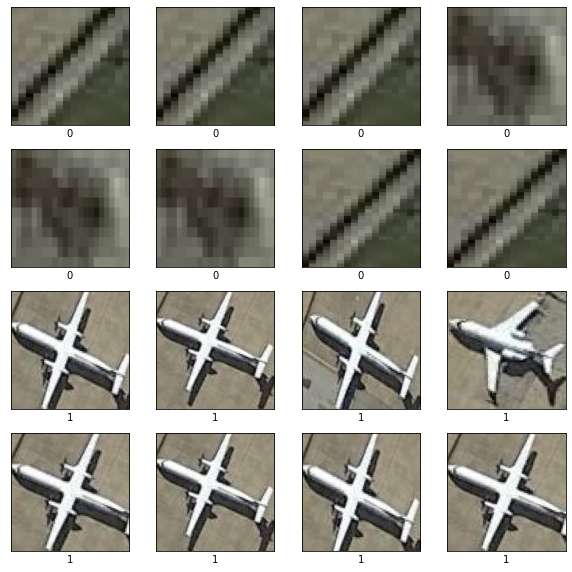

In [8]:
idx = []
for i in range(len(y_train)):
    if len(idx) < 8 and y_train[i] == 0:
        idx.append(i)
    elif len(idx) < 16 and y_train[i] == 1:
        idx.append(i)
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[idx[i]])
    plt.xlabel(y_train[idx[i]])
plt.show()

## CNN
We will use4 the VGG16 CNN model which is 16 layers deep and pre-trained to identify 1000 over classes.

In [9]:
vggmodel = VGG16(weights='imagenet', include_top=True)

We will do transfer learning on the imagenet weights (pre-trained to classify 1000 over different classes).

Freeze the first 15 layers, the 16th layer will be removed and a 2 unit softmax dense layer added to predict foreground or background.

Compile the model using Adam optimizer with learn rate of 0.0001. Categorical cross entropy as loss function since output is categorical.

In [10]:
# freeze 1st 15 layers
for layers in (vggmodel.layers)[:15]:
    layers.trainable = False
# take the 15 layers and add to our new model, append 2 uni softmax dense layer
X = vggmodel.layers[-2].output
predictions = Dense(2, activation="softmax")(X)
model_final = Model(inputs = vggmodel.input, outputs = predictions)
# compile
opt = Adam(lr=0.0001)
model_final.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics=["accuracy"])
model_final.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

## Preprocess our training data
One hot encode the label and spliting the dataset into train and test

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)
X_train, X_test, y_train, y_test = train_test_split(X_new, Y, test_size=0.10)

Use Keras ImageDataGenerator to pass the dataset to the model. Do some augmentation on the dataset like horizontal flip, vertical flip and rotation to increase the dataset.

In [12]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

## Train our model

In [13]:
hist = model_final.fit(traindata, steps_per_epoch=10, epochs=1000, 
                                 validation_data=testdata, validation_steps=2)

Epoch 1/1000
10/10 [==============================] - 54s 5s/step - loss: 0.8269 - accuracy: 0.8156 - val_loss: 0.2889 - val_accuracy: 0.9375
Epoch 2/1000
10/10 [==============================] - 54s 5s/step - loss: 0.4227 - accuracy: 0.8594 - val_loss: 0.3223 - val_accuracy: 0.8594
Epoch 3/1000
10/10 [==============================] - 54s 5s/step - loss: 0.1998 - accuracy: 0.9219 - val_loss: 0.6530 - val_accuracy: 0.9375
Epoch 4/1000
10/10 [==============================] - 52s 5s/step - loss: 0.2111 - accuracy: 0.9187 - val_loss: 0.0813 - val_accuracy: 0.9844
Epoch 5/1000
10/10 [==============================] - 52s 5s/step - loss: 0.1521 - accuracy: 0.9344 - val_loss: 0.1991 - val_accuracy: 0.9688
Epoch 6/1000
10/10 [==============================] - 53s 5s/step - loss: 0.1652 - accuracy: 0.9406 - val_loss: 0.1950 - val_accuracy: 0.9531
Epoch 7/1000
10/10 [==============================] - 52s 5s/step - loss: 0.1289 - accuracy: 0.9563 - val_loss: 0.1725 - val_accuracy: 0.9375
Epoch 

KeyboardInterrupt: 